In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import re
from Bio.Data import CodonTable
import textwrap
import ast
import scipy.stats as stats
standard_table = CodonTable.unambiguous_dna_by_id[1]

def readUsearchOutputTodf(filename):
    df_usearch = pd.read_csv(filename,delimiter='\t',\
                             names=['query','target','id','alnlen','mism','opens','qlo','qhi',\
                                    'tlo','thi','evalue','bits','qrow','trow','qrowdots','tstrand','qstrand']) 
    return df_usearch
def findMutInString(query):
    list_A = [m.start() for m in re.finditer('A',query )]
    list_T = [m.start() for m in re.finditer('T',query )]
    list_C = [m.start() for m in re.finditer('C',query )]
    list_G = [m.start() for m in re.finditer('G',query )]
    return {'A':list_A,'T':list_T,'C':list_C,'G':list_G}
    

def convertUsearchToValueCounts(inputFileName,countColumnName):
    """
    The following function converts the usearch input into a valu counts output
    The goal of the function is to reduce the usearch dataframes into simple readable value counts
    
    Input: inputFileName
    Output: a dataframe with read counts
    """
    df = readUsearchOutputTodf('Usearch/'+inputFileName+'.fastq.txt')
    series = df.qrowdots.value_counts()
    df_value_counts = pd.DataFrame(series)
    df_value_counts.columns = [countColumnName]
    df_value_counts['qrowdots'] = df_value_counts.index.values
    df_value_counts = df_value_counts.set_index(np.arange(0,len(series),1))
    df_value_counts = df_value_counts[['qrowdots',countColumnName]]
    return df_value_counts

def getMutationList(Mutations_Position):
    target = 'gtgcttggcaaaccgcaaacagacccgactctcgaatggttcttgtctcattgccacattcataagtacccatccaagagcacgcttattcaccagggtgaaaaagcggaaacgctgtactacatcgttaaaggctctgtggcagtgctgatcaaagacgaagagggtaaagaaatgatcctctcctatctgaatcagggtgattttattggcgaactgggcctgtttgaagagggccaggaacgtagcgcatgggtacgtgcgaaaacc'
    target_list = list(target)
    mutation = ''
    if type(Mutations_Position) == str:
        Mutations_Position = ast.literal_eval(Mutations_Position)
    for key in Mutations_Position.keys():
        if len(Mutations_Position[key]) > 0:
            for position in Mutations_Position[key]:
                mutation = mutation + target[position].upper()+str(position)+ key +','
    return mutation[:-1]

def codonChange(Mutations):
    if pd.isnull(Mutations) == False:
        try:
            coding_seq = 'gtgcttggcaaaccgcaaacagacccgactctcgaatggttcttgtctcattgccacattcataagtacccatccaagagcacgcttattcaccagggtgaaaaagcggaaacgctgtactacatcgttaaaggctctgtggcagtgctgatcaaagacgaagagggtaaagaaatgatcctctcctatctgaatcagggtgattttattggcgaactgggcctgtttgaagagggccaggaacgtagcgcatgggtacgtgcgaaaacc'
            codon_master_list = textwrap.wrap(coding_seq,3)
            codon_changes = ''
            position_list = []
            for mutation in Mutations.split(','):
                codon_pos = int((float(mutation[1:-1])-1)/3)
                if codon_pos not in position_list:
                    position_list.append(codon_pos)
                    codon = codon_master_list[int(codon_pos)]
                    codon_list = list(codon)
                    codon_list[int((float(mutation[1:-1]))%3)] = mutation[-1]
                    codon_changes = codon_changes+codon+str((int(mutation[1:-1]))/3)+"".join(codon_list) + ','
                else:
                    old_index = position_list.index(codon_pos)
                    codon = codon_master_list[int(codon_pos)]
                    codon_list = list(codon)
                    codon_list[int((float(mutation[1:-1]))%3)] = mutation[-1]
                    mutation = Mutations.split(',')[old_index]
                    codon_list[int((float(mutation[1:-1]))%3)] = mutation[-1]
                    codon_changes = codon_changes+codon+str((int(mutation[1:-1])-1)/3)+"".join(codon_list) + ','
                    l = codon_changes.split(",")
                    del l[old_index]
                    codon_changes = ",".join(l)
            return codon_changes[:-1]
        except ValueError:
            pass
        
def aachange(codon_changes):
    aa_change = ''
    if codon_changes is not None:
        for codon_change in codon_changes.split(','):
            if codon_change[-3:].upper() not in ['TAG','TGA','TAA']:
                aa_change = aa_change+standard_table.forward_table[codon_change[0:3].upper()]+\
                str(int(codon_change[3:-3])+1+1)+\
                standard_table.forward_table[codon_change[-3:].upper()]+","
            else:
                aa_change = aa_change+standard_table.forward_table[codon_change[0:3].upper()]+str(int(codon_change[3:-3])+1+518)+\
                '*'+","
    return aa_change[:-1]  

def identifyNonSynonymousMutations(aa_change): 
    mutations_list = []
    if pd.isnull(aa_change) == False and len(aa_change)>0:
        if "," in aa_change:
            for mutation in aa_change.split(","):
                if mutation[0].upper() != mutation[-1].upper():
                    mutations_list.append(mutation)
        else :
            if aa_change[0].upper() != aa_change[-1].upper():    
                mutations_list.append(aa_change)
    non_synonymous = ",".join(mutations_list)
    return non_synonymous


In [2]:
"""
Get data for the plasmid, linear and genome
"""
df_crp_lin = convertUsearchToValueCounts('2','crp_lin')
df_crp = convertUsearchToValueCounts('C_assembled','crp_gen')

In [ ]:
"""
For the donor and the genome, we get all mutational data: Data Mining
"""
def getMutationData(df_crp):
    df_crp = df_crp.assign(Mutations_Position = df_crp.qrowdots.apply(findMutInString))
    df_crp = df_crp.assign(Mutations = df_crp.Mutations_Position.apply(getMutationList))
    df_crp = df_crp.assign(Codon_Change = df_crp.Mutations.apply(codonChange)) 
    df_crp = df_crp.assign(AA_Change = df_crp.Codon_Change.apply(aachange)) 
    df_crp = df_crp.assign(No_Mutations = df_crp.Mutations.apply(lambda x: len(x.split(','))))
    df_crp = df_crp.assign(Non_Syn_Mutations = df_crp.AA_Change.apply(identifyNonSynonymousMutations))
    df_crp = df_crp.assign(No_Non_Syn = df_crp.Non_Syn_Mutations.apply(lambda x: len(x.split(','))))
    return df_crp


df_crp = df_crp.loc[df_crp.qrowdots.str.len() == 270]
df_crp_lin = df_crp_lin.loc[df_crp_lin.qrowdots.str.len() == 270]
df_crp_plas = df_crp_plas.loc[df_crp_plas.qrowdots.str.len() == 270]
df_crp = getMutationData(df_crp)
df_crp_plas = getMutationData(df_crp_plas)
df_crp_lin = getMutationData(df_crp_lin)

In [ ]:
"""
Measure Mutation Efficiencies
"""
print 100 - float(df_crp_lin.loc[df_crp_lin.Mutations == 'G140T'].crp_lin.sum())/df_crp_lin.crp_lin.sum()*100
print 100 - float(df_crp.loc[df_crp.Mutations == 'G140T'].crp_gen.sum())/df_crp.crp_gen.sum()*100

(0, 500)

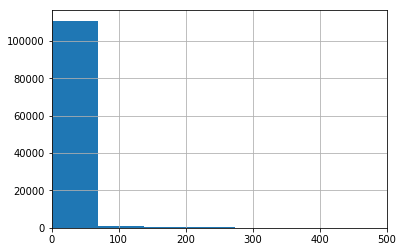

In [4]:
"""
Identify a cutoff to filter data on the genome
PCR and sequencing errors generate a lot of variants with very low counts. These low counts usually are erroneous.
Therefore, we make a histogram of read counts to estimate this number
Usually you get a Poisson like distribution. We estimate minimum counts based on the value where the curve tapers off
Here is an example.

In the following graph, we set can set the threshold between 50-100. 
Further filtering requires optimization which we discuss later.
"""
df_crp.crp_gen.hist(bins = 10000)
plt.xlim([0,500])

In [ ]:
"""
Save all data as csv files
"""
df_crp.to_csv('crp_gen.csv')
df_crp_lin.to_csv('crp_lin.csv')

In [101]:
"""
Read data from csv files
"""
df_crp = pd.read_csv('crp_gen.csv',index_col=0)
df_crp_lin = pd.read_csv('crp_lin.csv',index_col=0)

In [102]:
"""
Filter the data obtained from csv files
In our reads the first 20 and last 20 bases are control regions.
Therefore, we exclude all reads which have mutations in first and last 20 using the following function.
"""
def getFilteredMutationDataFrame(df):
    """
    Function to filter data
    Input: Counts Dataframe
    Output: Filtered Dataframe
    Here we also remove all variants with the count of 1. They constitute reads that are erroneous as discussed above.
    This threshold can be changed as per your assessment of possible erroneous counts discussed above
    """
    df_Filter = df.loc[~df.qrowdots.str[0:20].str.contains('A|T|C|G')]
    df_Filter = df_Filter.loc[~df_Filter.qrowdots.str[250:].str.contains('A|T|C|G')]
    return df_Filter
df_crp = df_crp.loc[df_crp.crp_gen >= 1]
df_crp = getFilteredMutationDataFrame(df_crp)
df_crp_lin = df_crp_lin.loc[df_crp_lin.crp_lin >= 1]
df_crp_lin = getFilteredMutationDataFrame(df_crp_lin)
df_crp.loc[pd.isna(df_crp.AA_Change) == True, 'No_Mutations'] = 0
df_crp_lin.loc[pd.isna(df_crp_lin.AA_Change) == True, 'No_Mutations'] = 0

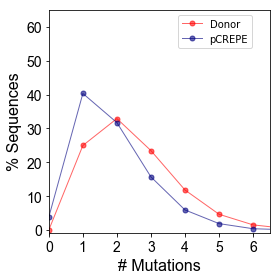

In [105]:
#The following graph is to get disctibution of sequeces based on number of Mutations on genome
%matplotlib inline
from matplotlib.ticker import MultipleLocator
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1, 1, 1)
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
plt.plot(df_crp_lin[['crp_lin','No_Mutations']].groupby('No_Mutations').sum()/df_crp_lin.crp_lin.sum()*100,\
         'o',linestyle = '-', color = 'red',label ='Donor', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_crp[['crp_gen','No_Mutations']].groupby('No_Mutations').sum()/df_crp.crp_gen.sum()*100,\
         'o',linestyle = '-', color = 'navy',label ='pCREPE', alpha = 0.6, markersize = 5, linewidth = 1)
plt.ylim([-0.8,65])
plt.xlim([0,6.5])
plt.ylabel('% Sequences',  fontname="Arial",fontsize = 16)
plt.xlabel('# Mutations',  fontname="Arial",fontsize = 16)
plt.xticks(np.arange(0, 7, 1.0), fontname="Arial",fontsize = 14)
plt.yticks(fontname="Arial",fontsize = 14)
ml = MultipleLocator()
ax.xaxis.set_minor_locator(ml)
plt.style.use('seaborn-pastel')
plt.legend(ncol = 1, loc = 'upper center', bbox_to_anchor = [0.75,1], fontsize = 10)
plt.tight_layout()
plt.savefig('Frequency_No_Mutations_crp.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

In [34]:
"""
Comparing percentages of different mutations between samples

The following code identifies mutations into 3 categors:
Syn: Synonymous substitutions
Non-syn: Non synonymous substitutions
Stop: Ssubstitutions with stop codon
"""
#We identify each non-synonymous mutation with a unique code
count = 0
for index in df_crp.loc[pd.isnull(df_crp.Non_Syn_Mutations) == True].index.values:
    df_crp.at[index,'Non_Syn_Mutations'] = 'SYN'+str(count)
    count = count+1

count = 0
for index in df_crp_lin.loc[pd.isnull(df_crp_lin.Non_Syn_Mutations) == True].index.values:
    df_crp_lin.at[index,'Non_Syn_Mutations'] = 'SYN'+str(count)
    count = count+1


#We annotate all synonymous, non-synonymous and stop codon mutations on the genome.
mask = (df_crp.Non_Syn_Mutations.str.find('SYN')>=0)
df_crp.loc[mask, 'Mutation_Type'] = 'Syn'

mask = (df_crp.Non_Syn_Mutations.str.find('SYN') <0)
df_crp.loc[mask, 'Mutation_Type'] = 'Non_Syn'

mask = (df_crp.Non_Syn_Mutations.str.find('*')>=0)
df_crp.loc[mask, 'Mutation_Type'] = 'Stop'

#We annotate all synonymous, non-synonymous and stop codon mutations on the genome.
mask = (df_crp_lin.Non_Syn_Mutations.str.find('SYN')>=0)
df_crp_lin.loc[mask, 'Mutation_Type'] = 'Syn'

mask = (df_crp_lin.Non_Syn_Mutations.str.find('SYN') <0)
df_crp_lin.loc[mask, 'Mutation_Type'] = 'Non_Syn'

mask = (df_crp_lin.Non_Syn_Mutations.str.find('*')>=0)
df_crp_lin.loc[mask, 'Mutation_Type'] = 'Stop'

In [35]:
#Get values for the Mutation type in donor and genome
print df_crp_lin[['Mutation_Type','crp_lin']].groupby('Mutation_Type').sum()
print df_crp[['Mutation_Type','crp_gen']].groupby('Mutation_Type').sum()

               crp_lin
Mutation_Type         
Non_Syn         477685
Stop             58801
Syn             340345
               crp_gen
Mutation_Type         
Non_Syn         750289
Stop             43649
Syn             938758


In [37]:
#Set the blank mutation as Wild_type in the population
for index in df_crp.loc[pd.isna(df_crp.Mutations) == True].index.values:
    df_crp.at[index,'Mutations'] = 'WT_True'
    df_crp.at[index,'Codon_Change'] = 'WT_True'
    df_crp.at[index,'AA_Change'] = 'WT_True'

for index in df_crp_lin.loc[pd.isna(df_crp_lin.Mutations) == True].index.values:
    df_crp_lin.at[index,'Mutations'] = 'WT_True'
    df_crp_lin.at[index,'Codon_Change'] = 'WT_True'
    df_crp_lin.at[index,'AA_Change'] = 'WT_True'

In [38]:
"""
We make a new dataframe comparing the frequency of sequences between the donor and the genome
"""
df_crp_genome = df_crp[['AA_Change','crp_gen']].groupby('AA_Change').sum()
df_crp_donor = df_crp_lin[['AA_Change','crp_lin']].groupby('AA_Change').sum()
df_crp_donor = df_crp_donor.join(df_crp_genome[['crp_gen']],how='outer')
df_crp_donor = df_crp_donor.fillna(0)

In [39]:
#We get the amino acid changes associated with each mutation
df_crp_donor = df_crp_donor.assign(AA_Change = df_crp_donor.index.values)
#We count the number of mutations per sequence
df_crp_donor = df_crp_donor.assign(No_Mutations = df_crp_donor.AA_Change.apply(lambda x: len(x.split(','))))
#We get a list of all non-synonymous mutations per sequence
df_crp_donor = df_crp_donor.assign(Non_Syn_Mutations = df_crp_donor.AA_Change.apply(identifyNonSynonymousMutations))
#We get the total number of non-synonumous mutations per sequence
df_crp_donor = df_crp_donor.assign(No_Non_Syn = df_crp_donor.Non_Syn_Mutations.apply(lambda x: len(x.split(','))))

In [40]:
df_crp_donor.loc[df_crp_donor.Non_Syn_Mutations == '','No_Non_Syn'] = 0
#we tak sum for all individual unique aa_changes combinations in the data
df_crp_donor = df_crp_donor.groupby(['AA_Change','Non_Syn_Mutations','No_Mutations','No_Non_Syn'],as_index=False).sum()
#We sort the values based on the number of reads before
adf_crp_donor = df_crp_donor.sort_values('crp_lin', ascending=0)
#We reset the index for the dataframe
df_crp_donor = df_crp_donor.reset_index(drop=True)

C:\Users\alaks\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'AA_Change' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\alaks\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


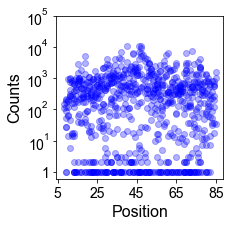

In [41]:
"""
The following code is to make the graph to show codon changes per position for sing codon changes and 
demonstrate the associated counts with these changes.
"""

def getUniqueMutation(AA_Change):
    string = AA_Change.replace('V48V','')
    string = string.replace(',','')
    return string
df_crp_donor_single = df_crp_donor.loc[df_crp_donor.No_Mutations == 2]
df_crp_donor_single = df_crp_donor_single.loc[df_crp_donor_single.AA_Change.str.find('V48V') >= 0]
df_crp_donor_single = df_crp_donor_single.loc[df_crp_donor_single.AA_Change.str.find('*') < 0]
df_crp_donor_single = df_crp_donor_single.assign(Unique_Mut = df_crp_donor_single.AA_Change.apply(getUniqueMutation))
df_crp_positionwise = df_crp_donor_single[['Unique_Mut','crp_gen']]
df_crp_positionwise = df_crp_positionwise.assign(Position = pd.to_numeric(df_crp_positionwise.Unique_Mut.str[1:-1]))


fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(df_crp_positionwise.Position,np.log10(df_crp_positionwise.crp_gen), color = 'blue', alpha = 0.3)
plt.yticks(np.arange(0,6,1),fontname="Arial",fontsize = 14)
ax.set_yticklabels(['1','$\mathregular{10^1}$','$\mathregular{10^2}$','$\mathregular{10^3}$','$\mathregular{10^4}$','$\mathregular{10^5}$'])
plt.xticks(np.arange(df_crp_positionwise.Position.min()-3,df_crp_positionwise.Position.max()+20,20),\
          fontname="Arial",fontsize = 14)
plt.xlabel('Position',fontname="Arial",fontsize = 16)
plt.ylabel('Counts',fontname="Arial",fontsize = 16)
plt.savefig('crp_countsbyposition.svg', format = 'svg', dpi = 300)

In [42]:
"""
In the above graph you observe that the density of mutations are high in 2 regions. 
1. Around 1 (10^0)
2. Between 10^2 and 10^3 reads.

The botton high density is coming from erroneous reads. Errors may be introduced during sequencing and during PCR.

So we set a threshold of 30 to filter such erroenous reads.
"""

filter_value = 30
print filter_value

condition_B = (df_crp_donor.crp_lin >= filter_value) | (df_crp_donor.crp_gen >= filter_value)

df_crp_donor = df_crp_donor.loc[condition_B]

30


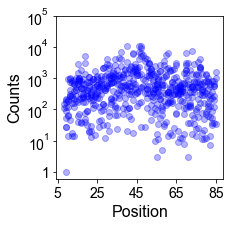

In [44]:
"""
The following code is to make the graph to show codon changes per position for sing codon changes and 
demonstrate the associated counts with these changes.

We observe that after applying the filter, we now have a cleaner graph with most mutations occurring only between 10^2 and 10^3 reads
"""
def getUniqueMutation(AA_Change):
    string = AA_Change.replace('V48V','')
    string = string.replace(',','')
    return string
df_crp_donor_single = df_crp_donor.loc[df_crp_donor.No_Mutations == 2]
df_crp_donor_single = df_crp_donor_single.loc[df_crp_donor_single.AA_Change.str.find('V48V') >= 0]
df_crp_donor_single = df_crp_donor_single.loc[df_crp_donor_single.AA_Change.str.find('*') < 0]
df_crp_donor_single = df_crp_donor_single.assign(Unique_Mut = df_crp_donor_single.AA_Change.apply(getUniqueMutation))
df_crp_positionwise = df_crp_donor_single[['Unique_Mut','crp_gen']]
df_crp_positionwise = df_crp_positionwise.assign(Position = pd.to_numeric(df_crp_positionwise.Unique_Mut.str[1:-1]))


fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(df_crp_positionwise.Position,np.log10(df_crp_positionwise.crp_gen), color = 'blue', alpha = 0.3)
plt.yticks(np.arange(0,6,1),fontname="Arial",fontsize = 14)
ax.set_yticklabels(['1','$\mathregular{10^1}$','$\mathregular{10^2}$','$\mathregular{10^3}$','$\mathregular{10^4}$','$\mathregular{10^5}$'])
plt.xticks(np.arange(df_crp_positionwise.Position.min()-3,df_crp_positionwise.Position.max()+20,20),\
          fontname="Arial",fontsize = 14)
plt.xlabel('Position',fontname="Arial",fontsize = 16)
plt.ylabel('Counts',fontname="Arial",fontsize = 16)
plt.savefig('crp_countsbyposition.svg', format = 'svg', dpi = 300)

In [127]:
"""
We use the filteres dataframe to get mean codon changes per position.
"""
df_crp_positionwise.Position.value_counts().mean()

7.756410256410256

In [48]:
"""
We use the filteres dataframe to get median counts per position
"""
df_crp_positionwise.crp_gen.median()

439.0

In [49]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import re
from Bio.Data import CodonTable
import textwrap
import ast
import scipy.stats as stats
standard_table = CodonTable.unambiguous_dna_by_id[1]

def readUsearchOutputTodf(filename):
    df_usearch = pd.read_csv(filename,delimiter='\t',\
                             names=['query','target','id','alnlen','mism','opens','qlo','qhi',\
                                    'tlo','thi','evalue','bits','qrow','trow','qrowdots','tstrand','qstrand']) 
    return df_usearch
def findMutInString(query):
    list_A = [m.start() for m in re.finditer('A',query )]
    list_T = [m.start() for m in re.finditer('T',query )]
    list_C = [m.start() for m in re.finditer('C',query )]
    list_G = [m.start() for m in re.finditer('G',query )]
    return {'A':list_A,'T':list_T,'C':list_C,'G':list_G}
    

def convertUsearchToValueCounts(inputFileName,countColumnName):
    """
    The following function converts the usearch input into a valu counts output
    The goal of the function is to reduce the usearch dataframes into simple readable value counts
    
    Input: inputFileName
    Output: a dataframe with read counts
    """
    df = readUsearchOutputTodf('Usearch/'+inputFileName+'.fastq.txt')
    series = df.qrowdots.value_counts()
    df_value_counts = pd.DataFrame(series)
    df_value_counts.columns = [countColumnName]
    df_value_counts['qrowdots'] = df_value_counts.index.values
    df_value_counts = df_value_counts.set_index(np.arange(0,len(series),1))
    df_value_counts = df_value_counts[['qrowdots',countColumnName]]
    return df_value_counts

def getMutationList(Mutations_Position):
    target = 'cggcgttatcgccgacttcttcgtgactgaaaaaatgctccagcacttcatcaaacaagtgcacagcaacagctttatgcgtccaagcccgcgcgttctggtttgtgtgccggttggcgcgacccaggttgaacgccgcgcaattcgtgaatccgcgcagggcgctggtgcccgtgaagtcttcctgattgaagaaccgatggctgccgcaattggtgctggcctgccggtttctgaagcgaccggttctatggtggttgatatcggtgg'
    target_list = list(target)
    mutation = ''
    if type(Mutations_Position) == str:
        Mutations_Position = ast.literal_eval(Mutations_Position)
    for key in Mutations_Position.keys():
        if len(Mutations_Position[key]) > 0:
            for position in Mutations_Position[key]:
                mutation = mutation + target[position].upper()+str(position)+ key +','
    return mutation[:-1]

def codonChange(Mutations):
    if pd.isnull(Mutations) == False:
        try:
            coding_seq = 'ggcgttatcgccgacttcttcgtgactgaaaaaatgctccagcacttcatcaaacaagtgcacagcaacagctttatgcgtccaagcccgcgcgttctggtttgtgtgccggttggcgcgacccaggttgaacgccgcgcaattcgtgaatccgcgcagggcgctggtgcccgtgaagtcttcctgattgaagaaccgatggctgccgcaattggtgctggcctgccggtttctgaagcgaccggttctatggtggttgatatcggtggt'
            codon_master_list = textwrap.wrap(coding_seq,3)
            codon_changes = ''
            position_list = []
            for mutation in Mutations.split(','):
                codon_pos = int((float(mutation[1:-1])-1)/3)
                if codon_pos not in position_list:
                    position_list.append(codon_pos)
                    codon = codon_master_list[int(codon_pos)]
                    codon_list = list(codon)
                    codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                    codon_changes = codon_changes+codon+str((int(mutation[1:-1])-1)/3)+"".join(codon_list) + ','
                else:
                    old_index = position_list.index(codon_pos)
                    codon = codon_master_list[int(codon_pos)]
                    codon_list = list(codon)
                    codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                    mutation = Mutations.split(',')[old_index]
                    codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                    codon_changes = codon_changes+codon+str((int(mutation[1:-1])-1)/3)+"".join(codon_list) + ','
                    l = codon_changes.split(",")
                    del l[old_index]
                    codon_changes = ",".join(l)
            return codon_changes[:-1]
        except ValueError:
            pass
        
def aachange(codon_changes):
    #print codon_changes
    aa_change = ''
    if codon_changes is not None:
        for codon_change in codon_changes.split(','):
            if codon_change[-3:].upper() not in ['TAG','TGA','TAA','GG8']:
                aa_change = aa_change+standard_table.forward_table[codon_change[0:3].upper()]+\
                str(int(codon_change[3:-3])+1+78)+\
                standard_table.forward_table[codon_change[-3:].upper()]+","
            else:
                aa_change = aa_change+standard_table.forward_table[codon_change[0:3].upper()]+str(int(codon_change[3:-3])+1+518)+\
                '*'+","
    return aa_change[:-1]  

def identifyNonSynonymousMutations(aa_change): 
    mutations_list = []
    if pd.isnull(aa_change) == False and len(aa_change)>0:
        if "," in aa_change:
            for mutation in aa_change.split(","):
                if mutation[0].upper() != mutation[-1].upper():
                    mutations_list.append(mutation)
        else :
            if aa_change[0].upper() != aa_change[-1].upper():    
                mutations_list.append(aa_change)
    non_synonymous = ",".join(mutations_list)
    return non_synonymous

In [ ]:
"""
Get data for the plasmid, linear and genome
"""
df_mreB_lin = convertUsearchToValueCounts('4','mreB_lin')
df_mreB = convertUsearchToValueCounts('M_assembled','mreB')
df_mreB = df_mreB.loc[df_mreB.qrowdots.str.len() == 270]
df_mreB_lin = df_mreB_lin.loc[df_mreB_lin.qrowdots.str.len() == 270]

In [ ]:
"""
For the donor and the genome, we get all mutational data: Data Mining
"""
def getMutationData(df_mreB):
    df_mreB = df_mreB.assign(Mutations_Position = df_mreB.qrowdots.apply(findMutInString))
    df_mreB = df_mreB.assign(Mutations = df_mreB.Mutations_Position.apply(getMutationList))
    df_mreB = df_mreB.assign(Codon_Change = df_mreB.Mutations.apply(codonChange)) 
    df_mreB = df_mreB.assign(AA_Change = df_mreB.Codon_Change.apply(aachange)) 
    df_mreB = df_mreB.assign(No_Mutations = df_mreB.Mutations.apply(lambda x: len(x.split(','))))
    df_mreB = df_mreB.assign(Non_Syn_Mutations = df_mreB.AA_Change.apply(identifyNonSynonymousMutations))
    df_mreB = df_mreB.assign(No_Non_Syn = df_mreB.Non_Syn_Mutations.apply(lambda x: len(x.split(','))))
    return df_mreB

df_mreB_lin = getMutationData(df_mreB_lin)
df_mreB = getMutationData(df_mreB)

In [52]:
print 100 - float(df_mreB_lin.loc[df_mreB_lin.Mutations == 'C135T'].mreB_lin.sum())/df_mreB_lin.mreB_lin.sum()*100
print 100 - float(df_mreB.loc[df_mreB.Mutations == 'C135T'].mreB.sum())/df_mreB.mreB.sum()*100

76.53518763212224
52.92257232550536


In [ ]:
df_mreB.to_csv('mreB_gen.csv')
df_mreB_lin.to_csv('mreB_lin.csv')

In [98]:
df_mreB = pd.read_csv('mreB_gen.csv',index_col=0)
df_mreB_lin = pd.read_csv('mreB_lin.csv',index_col=0)

In [99]:
"""
Filter the data obtained from csv files
In our reads the first 20 and last 20 bases are control regions.
Therefore, we exclude all reads which have mutations in first and last 20 using the following function.
"""
def getFilteredMutationDataFrame(df):
    """
    Function to filter data
    Input: Counts Dataframe
    Output: Filtered Dataframe
    Here we also remove all variants with the count of 1. They constitute reads that are erroneous as discussed above.
    This threshold can be changed as per your assessment of possible erroneous counts discussed above
    """
    df_Filter = df.loc[~df.qrowdots.str[0:20].str.contains('A|T|C|G')]
    df_Filter = df_Filter.loc[~df_Filter.qrowdots.str[250:].str.contains('A|T|C|G')]
    return df_Filter
df_mreB = df_mreB.loc[df_mreB.mreB >= 1]
df_mreB = getFilteredMutationDataFrame(df_mreB)
df_mreB_lin = df_mreB_lin.loc[df_mreB_lin.mreB_lin >= 1]
df_mreB_lin = getFilteredMutationDataFrame(df_mreB_lin)
df_mreB.loc[pd.isna(df_mreB.AA_Change) == True, 'No_Mutations'] = 0
df_mreB_lin.loc[pd.isna(df_mreB_lin.AA_Change) == True, 'No_Mutations'] = 0

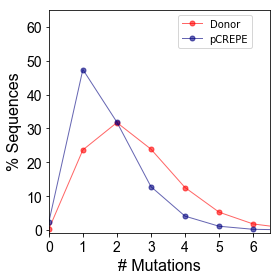

In [107]:
%matplotlib inline
from matplotlib.ticker import MultipleLocator
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1, 1, 1)
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
plt.plot(df_mreB_lin[['mreB_lin','No_Mutations']].groupby('No_Mutations').sum()/df_mreB_lin.mreB_lin.sum()*100,\
         'o',linestyle = '-', color = 'red',label ='Donor', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_mreB[['mreB','No_Mutations']].groupby('No_Mutations').sum()/df_mreB.mreB.sum()*100,\
         'o',linestyle = '-', color = 'navy',label ='pCREPE', alpha = 0.6, markersize = 5, linewidth = 1)
plt.ylim([-0.8,65])
plt.xlim([0,6.5])
plt.ylabel('% Sequences',  fontname="Arial",fontsize = 16)
plt.xlabel('# Mutations',  fontname="Arial",fontsize = 16)
plt.xticks(np.arange(0, 7, 1.0), fontname="Arial",fontsize = 14)
plt.yticks(fontname="Arial",fontsize = 14)
ml = MultipleLocator()
ax.xaxis.set_minor_locator(ml)
plt.style.use('seaborn-pastel')
plt.legend(ncol = 1, loc = 'upper center', bbox_to_anchor = [0.75,1], fontsize = 10)
plt.tight_layout()
plt.savefig('Frequency_No_Mutations_mreB.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

In [62]:
"""
Comparing percentages of different mutations between samples

The following code identifies mutations into 3 categors:
Syn: Synonymous substitutions
Non-syn: Non synonymous substitutions
Stop: Ssubstitutions with stop codon
"""
#We identify each non-synonymous mutation with a unique code
count = 0
for index in df_mreB.loc[pd.isnull(df_mreB.Non_Syn_Mutations) == True].index.values:
    df_mreB.at[index,'Non_Syn_Mutations'] = 'SYN'+str(count)
    count = count+1

count = 0
for index in df_mreB_lin.loc[pd.isnull(df_mreB_lin.Non_Syn_Mutations) == True].index.values:
    df_mreB_lin.at[index,'Non_Syn_Mutations'] = 'SYN'+str(count)
    count = count+1


mask = (df_mreB.Non_Syn_Mutations.str.find('SYN')>=0)
df_mreB.loc[mask, 'Mutation_Type'] = 'Syn'

mask = (df_mreB.Non_Syn_Mutations.str.find('SYN') <0)
df_mreB.loc[mask, 'Mutation_Type'] = 'Non_Syn'

mask = (df_mreB.Non_Syn_Mutations.str.find('*')>=0)
df_mreB.loc[mask, 'Mutation_Type'] = 'Stop'

mask = (df_mreB_lin.Non_Syn_Mutations.str.find('SYN')>=0)
df_mreB_lin.loc[mask, 'Mutation_Type'] = 'Syn'

mask = (df_mreB_lin.Non_Syn_Mutations.str.find('SYN') <0)
df_mreB_lin.loc[mask, 'Mutation_Type'] = 'Non_Syn'

mask = (df_mreB_lin.Non_Syn_Mutations.str.find('*')>=0)
df_mreB_lin.loc[mask, 'Mutation_Type'] = 'Stop'

In [63]:
print df_mreB_lin[['Mutation_Type','mreB_lin']].groupby('Mutation_Type').sum()
print df_mreB[['Mutation_Type','mreB']].groupby('Mutation_Type').sum()

               mreB_lin
Mutation_Type          
Non_Syn          634370
Stop              33827
Syn              343650
                  mreB
Mutation_Type         
Non_Syn         704551
Stop              3209
Syn            1041692


In [64]:
for index in df_mreB.loc[pd.isna(df_mreB.Mutations) == True].index.values:
    df_mreB.at[index,'Mutations'] = 'WT_True'
    df_mreB.at[index,'Codon_Change'] = 'WT_True'
    df_mreB.at[index,'AA_Change'] = 'WT_True'
df_mreB

for index in df_mreB_lin.loc[pd.isna(df_mreB_lin.Mutations) == True].index.values:
    df_mreB_lin.at[index,'Mutations'] = 'WT_True'
    df_mreB_lin.at[index,'Codon_Change'] = 'WT_True'
    df_mreB_lin.at[index,'AA_Change'] = 'WT_True'

In [70]:
"""
We make a new dataframe comparing the frequency of sequences between the donor and the genome
"""
df_mreB_genome = df_mreB[['AA_Change','mreB']].groupby('AA_Change').sum()
df_mreB_donor = df_mreB_lin[['AA_Change','mreB_lin']].groupby('AA_Change').sum()
df_mreB_donor = df_mreB_donor.join(df_mreB_genome[['mreB']],how='outer')
df_mreB_donor = df_mreB_donor.fillna(0)

In [71]:
#We get the amino acid changes associated with each mutation
df_mreB_donor = df_mreB_donor.assign(AA_Change = df_mreB_donor.index.values)
#We count the number of mutations per sequence
df_mreB_donor = df_mreB_donor.assign(No_Mutations = df_mreB_donor.AA_Change.apply(lambda x: len(x.split(','))))
#We get a list of all non-synonymous mutations per sequence
df_mreB_donor = df_mreB_donor.assign(Non_Syn_Mutations = df_mreB_donor.AA_Change.apply(identifyNonSynonymousMutations))
#We get the total number of non-synonumous mutations per sequence
df_mreB_donor = df_mreB_donor.assign(No_Non_Syn = df_mreB_donor.Non_Syn_Mutations.apply(lambda x: len(x.split(','))))

df_mreB_donor.loc[df_mreB_donor.Non_Syn_Mutations == '','No_Non_Syn'] = 0
#we tak sum for all individual unique aa_changes combinations in the data
df_mreB_donor = df_mreB_donor.groupby(['AA_Change','Non_Syn_Mutations','No_Mutations','No_Non_Syn'],as_index=False).sum()
#We sort the values based on the number of reads before
df_mreB_donor = df_mreB_donor.sort_values('mreB_lin', ascending=0)
#We reset the index for the dataframe
df_mreB_donor = df_mreB_donor.reset_index(drop=True)

C:\Users\alaks\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 'AA_Change' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if sys.path[0] == '':


In [72]:
#We identify each non-synonymous mutation with a unique code
count = 0
for index in df_mreB_donor.loc[df_mreB_donor.Non_Syn_Mutations == ""].index.values:
    df_mreB_donor.at[index,'Non_Syn_Mutations'] = 'SYN'+str(count)
    count = count+1

In [74]:
#We assign the SPM as the wildtype reference.
df_mreB_donor.at[0,'Non_Syn_Mutations'] = 'WT'
#We identify each non-synonymous mutation with a unique code
count = 0
for index in df_mreB_donor.loc[df_mreB_donor.Non_Syn_Mutations == ''].index.values:
    df_mreB_donor.at[index,'Non_Syn_Mutations'] = 'SYN'+str(count)
    count = count+1

C:\Users\alaks\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


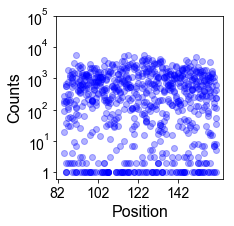

In [75]:
"""
The following code is to make the graph to show codon changes per position for sing codon changes and 
demonstrate the associated counts with these changes.
"""
def getUniqueMutation(AA_Change):
    string = AA_Change.replace('R123R','')
    string = string.replace(',','')
    return string
df_mreB_donor_single = df_mreB_donor.loc[df_mreB_donor.No_Mutations == 2]
df_mreB_donor_single = df_mreB_donor_single.loc[df_mreB_donor_single.AA_Change.str.find('R123R') >= 0]
df_mreB_donor_single = df_mreB_donor_single.loc[df_mreB_donor_single.AA_Change.str.find('*') < 0]
df_mreB_donor_single = df_mreB_donor_single.assign(Unique_Mut = df_mreB_donor_single.AA_Change.apply(getUniqueMutation))
df_mreB_positionwise = df_mreB_donor_single[['Unique_Mut','mreB']]
df_mreB_positionwise = df_mreB_positionwise.assign(Position = pd.to_numeric(df_mreB_positionwise.Unique_Mut.str[1:-1]))


fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(df_mreB_positionwise.Position,np.log10(df_mreB_positionwise.mreB), color = 'blue', alpha = 0.3)
plt.yticks(np.arange(0,6,1),fontname="Arial",fontsize = 14)
ax.set_yticklabels(['1','$\mathregular{10^1}$','$\mathregular{10^2}$','$\mathregular{10^3}$','$\mathregular{10^4}$','$\mathregular{10^5}$'])
plt.xticks(np.arange(df_mreB_positionwise.Position.min()-3,df_mreB_positionwise.Position.max(),20),\
          fontname="Arial",fontsize = 14)
plt.xlabel('Position',fontname="Arial",fontsize = 16)
plt.ylabel('Counts',fontname="Arial",fontsize = 16)
plt.savefig('mreB_countsbyposition.svg', format = 'svg', dpi = 300)

In [76]:
filter_value = 30
print filter_value

condition_B = (df_mreB_donor.mreB_lin >= filter_value) | (df_mreB_donor.mreB >= filter_value)

df_mreB_donor = df_mreB_donor.loc[condition_B]

30


C:\Users\alaks\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


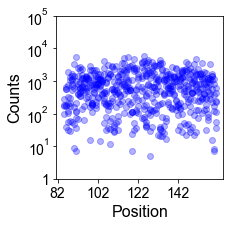

In [80]:
"""
The following code is to make the graph to show codon changes per position for sing codon changes and 
demonstrate the associated counts with these changes.

We observe that after applying the filter, we now have a cleaner graph with most mutations occurring only between 10^2 and 10^3 reads
"""
def getUniqueMutation(AA_Change):
    string = AA_Change.replace('R123R','')
    string = string.replace(',','')
    return string
df_mreB_donor_single = df_mreB_donor.loc[df_mreB_donor.No_Mutations == 2]
df_mreB_donor_single = df_mreB_donor_single.loc[df_mreB_donor_single.AA_Change.str.find('R123R') >= 0]
df_mreB_donor_single = df_mreB_donor_single.loc[df_mreB_donor_single.AA_Change.str.find('*') < 0]
df_mreB_donor_single = df_mreB_donor_single.assign(Unique_Mut = df_mreB_donor_single.AA_Change.apply(getUniqueMutation))
df_mreB_positionwise = df_mreB_donor_single[['Unique_Mut','mreB']]
df_mreB_positionwise = df_mreB_positionwise.assign(Position = pd.to_numeric(df_mreB_positionwise.Unique_Mut.str[1:-1]))


fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(df_mreB_positionwise.Position,np.log10(df_mreB_positionwise.mreB), color = 'blue', alpha = 0.3)
plt.yticks(np.arange(0,6,1),fontname="Arial",fontsize = 14)
ax.set_yticklabels(['1','$\mathregular{10^1}$','$\mathregular{10^2}$','$\mathregular{10^3}$','$\mathregular{10^4}$','$\mathregular{10^5}$'])
plt.xticks(np.arange(df_mreB_positionwise.Position.min()-3,df_mreB_positionwise.Position.max(),20),\
          fontname="Arial",fontsize = 14)
plt.xlabel('Position',fontname="Arial",fontsize = 16)
plt.ylabel('Counts',fontname="Arial",fontsize = 16)
plt.savefig('mreB_countsbyposition.svg', format = 'svg', dpi = 300)

In [87]:
filter_value = 30
print filter_value

condition_B = (df_mreB_donor.mreB_lin >= filter_value) | (df_mreB_donor.mreB >= 250)

df_mreB_donor = df_mreB_donor.loc[condition_B]

def getUniqueMutation(AA_Change):
    string = AA_Change.replace('R123R','')
    string = string.replace(',','')
    return string
df_mreB_donor_single = df_mreB_donor.loc[df_mreB_donor.No_Mutations == 2]
df_mreB_donor_single = df_mreB_donor_single.loc[df_mreB_donor_single.AA_Change.str.find('R123R') >= 0]
df_mreB_donor_single = df_mreB_donor_single.loc[df_mreB_donor_single.AA_Change.str.find('*') < 0]
df_mreB_donor_single = df_mreB_donor_single.assign(Unique_Mut = df_mreB_donor_single.AA_Change.apply(getUniqueMutation))
df_mreB_positionwise = df_mreB_donor_single[['Unique_Mut','mreB']]
df_mreB_positionwise = df_mreB_positionwise.assign(Position = pd.to_numeric(df_mreB_positionwise.Unique_Mut.str[1:-1]))

30


In [88]:
df_mreB_positionwise.Position.value_counts().mean()

7.526315789473684

In [89]:
df_mreB_positionwise.mreB.median()

613.5

In [90]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import re
from Bio.Data import CodonTable
import textwrap
import ast
import scipy.stats as stats
standard_table = CodonTable.unambiguous_dna_by_id[1]

def readUsearchOutputTodf(filename):
    df_usearch = pd.read_csv(filename,delimiter='\t',\
                             names=['query','target','id','alnlen','mism','opens','qlo','qhi',\
                                    'tlo','thi','evalue','bits','qrow','trow','qrowdots','tstrand','qstrand']) 
    return df_usearch
def findMutInString(query):
    list_A = [m.start() for m in re.finditer('A',query )]
    list_T = [m.start() for m in re.finditer('T',query )]
    list_C = [m.start() for m in re.finditer('C',query )]
    list_G = [m.start() for m in re.finditer('G',query )]
    return {'A':list_A,'T':list_T,'C':list_C,'G':list_G}
    

def convertUsearchToValueCounts(inputFileName,countColumnName):
    """
    The following function converts the usearch input into a valu counts output
    The goal of the function is to reduce the usearch dataframes into simple readable value counts
    
    Input: inputFileName
    Output: a dataframe with read counts
    """
    df = readUsearchOutputTodf('Usearch/'+inputFileName+'.fastq.txt')
    series = df.qrowdots.value_counts()
    df_value_counts = pd.DataFrame(series)
    df_value_counts.columns = [countColumnName]
    df_value_counts['qrowdots'] = df_value_counts.index.values
    df_value_counts = df_value_counts.set_index(np.arange(0,len(series),1))
    df_value_counts = df_value_counts[['qrowdots',countColumnName]]
    return df_value_counts

def getMutationList(Mutations_Position):
    target = 'caacccgctgtctgagattacgcacaaacgtcgtatctccgcactcggcccaggcggtctgacccgtgaacgtgcaggcttcgaagttcgagacgtacacccgactcactacggtcgcgtatgtccaatcgaaacccctgaaggtccgaacatcggtctgatcaactctctgtccgtgtacgcacagactaacgaatacggcttccttgagactccgtatcgtaaagtgaccgacggtgttgtaactgacgaaattcactacctgtctgcnnnnn'
    target_list = list(target)
    mutation = ''
    if type(Mutations_Position) == str:
        Mutations_Position = ast.literal_eval(Mutations_Position)
    for key in Mutations_Position.keys():
        if len(Mutations_Position[key]) > 0:
            for position in Mutations_Position[key]:
                mutation = mutation + target[position].upper()+str(position)+ key +','
    return mutation[:-1]

def codonChange(Mutations):
    if pd.isnull(Mutations) == False:
        try:
            coding_seq = 'aacccgctgtctgagattacgcacaaacgtcgtatctccgcactcggcccaggcggtctgacccgtgaacgtgcaggcttcgaagttcgagacgtacacccgactcactacggtcgcgtatgtccaatcgaaacccctgaaggtccgaacatcggtctgatcaactctctgtccgtgtacgcacagactaacgaatacggcttccttgagactccgtatcgtaaagtgaccgacggtgttgtaactgacgaaattcactacctgtctgct'
            codon_master_list = textwrap.wrap(coding_seq,3)
            codon_changes = ''
            position_list = []
            for mutation in Mutations.split(','):
                codon_pos = int((float(mutation[1:-1])-1)/3)
                if codon_pos not in position_list:
                    position_list.append(codon_pos)
                    codon = codon_master_list[int(codon_pos)]
                    codon_list = list(codon)
                    codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                    codon_changes = codon_changes+codon+str((int(mutation[1:-1])-1)/3)+"".join(codon_list) + ','
                else:
                    old_index = position_list.index(codon_pos)
                    codon = codon_master_list[int(codon_pos)]
                    codon_list = list(codon)
                    codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                    mutation = Mutations.split(',')[old_index]
                    codon_list[int((float(mutation[1:-1])-1)%3)] = mutation[-1]
                    codon_changes = codon_changes+codon+str((int(mutation[1:-1])-1)/3)+"".join(codon_list) + ','
                    l = codon_changes.split(",")
                    del l[old_index]
                    codon_changes = ",".join(l)
            return codon_changes[:-1]
        except ValueError:
            pass
        
def aachange(codon_changes):
    aa_change = ''
    if codon_changes is not None:
        for codon_change in codon_changes.split(','):
            if codon_change[-3:].upper() not in ['TAG','TGA','TAA']:
                aa_change = aa_change+standard_table.forward_table[codon_change[0:3].upper()]+\
                str(int(codon_change[3:-3])+1+518)+\
                standard_table.forward_table[codon_change[-3:].upper()]+","
            else:
                aa_change = aa_change+standard_table.forward_table[codon_change[0:3].upper()]+str(int(codon_change[3:-3])+1+518)+\
                '*'+","
    return aa_change[:-1]  

def identifyNonSynonymousMutations(aa_change): 
    mutations_list = []
    if pd.isnull(aa_change) == False and len(aa_change)>0:
        if "," in aa_change:
            for mutation in aa_change.split(","):
                if mutation[0].upper() != mutation[-1].upper():
                    mutations_list.append(mutation)
        else :
            if aa_change[0].upper() != aa_change[-1].upper():    
                mutations_list.append(aa_change)
    non_synonymous = ",".join(mutations_list)
    return non_synonymous

In [ ]:
df_rpoB_lin = convertUsearchToValueCounts('6','rpoB_lin')
df_rpoB = convertUsearchToValueCounts('Init-Pre_assembled','rpoB')
df_rpoB = df_rpoB.loc[df_rpoB.qrowdots.str.len() == 270]
df_rpoB_lin = df_rpoB_lin.loc[df_rpoB_lin.qrowdots.str.len() == 270]

In [ ]:
"""
For the donor and the genome, we get all mutational data: Data Mining
"""
def getMutationData(df_rpoB):
    df_rpoB = df_rpoB.assign(Mutations_Position = df_rpoB.qrowdots.apply(findMutInString))
    df_rpoB = df_rpoB.assign(Mutations = df_rpoB.Mutations_Position.apply(getMutationList))
    df_rpoB = df_rpoB.assign(Codon_Change = df_rpoB.Mutations.apply(codonChange)) 
    df_rpoB = df_rpoB.assign(AA_Change = df_rpoB.Codon_Change.apply(aachange)) 
    df_rpoB = df_rpoB.assign(No_Mutations = df_rpoB.Mutations.apply(lambda x: len(x.split(','))))
    df_rpoB = df_rpoB.assign(Non_Syn_Mutations = df_rpoB.AA_Change.apply(identifyNonSynonymousMutations))
    df_rpoB = df_rpoB.assign(No_Non_Syn = df_rpoB.Non_Syn_Mutations.apply(lambda x: len(x.split(','))))
    return df_rpoB

df_rpoB_plas = getMutationData(df_rpoB_plas)
df_rpoB_lin = getMutationData(df_rpoB_lin)
df_rpoB = getMutationData(df_rpoB)

In [ ]:
df_rpoB.to_csv('rpoB_gen.csv')
df_rpoB_lin.to_csv('rpoB_lin.csv')

In [91]:
df_rpoB = pd.read_csv('rpoB_gen.csv',index_col=0)
df_rpoB_lin = pd.read_csv('rpoB_lin.csv',index_col=0)

In [94]:
"""
Filter the data obtained from csv files
In our reads the first 20 and last 20 bases are control regions.
Therefore, we exclude all reads which have mutations in first and last 20 using the following function.
"""
def getFilteredMutationDataFrame(df):
    """
    Function to filter data
    Input: Counts Dataframe
    Output: Filtered Dataframe
    Here we also remove all variants with the count of 1. They constitute reads that are erroneous as discussed above.
    This threshold can be changed as per your assessment of possible erroneous counts discussed above
    """
    df_Filter = df.loc[~df.qrowdots.str[0:20].str.contains('A|T|C|G')]
    df_Filter = df_Filter.loc[~df_Filter.qrowdots.str[250:].str.contains('A|T|C|G')]
    return df_Filter
df_rpoB = df_rpoB.loc[df_rpoB.rpoB >= 1]
df_rpoB = getFilteredMutationDataFrame(df_rpoB)
df_rpoB_lin = df_rpoB_lin.loc[df_rpoB_lin.rpoB_lin >= 1]
df_rpoB_lin = getFilteredMutationDataFrame(df_rpoB_lin)
df_rpoB.loc[pd.isna(df_rpoB.AA_Change) == True, 'No_Mutations'] = 0
df_rpoB_lin.loc[pd.isna(df_rpoB_lin.AA_Change) == True, 'No_Mutations'] = 0

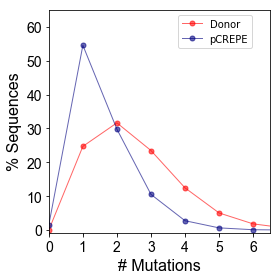

In [109]:
%matplotlib inline
from matplotlib.ticker import MultipleLocator
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1, 1, 1)
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
plt.plot(df_rpoB_lin[['rpoB_lin','No_Mutations']].groupby('No_Mutations').sum()/df_rpoB_lin.rpoB_lin.sum()*100,\
         'o',linestyle = '-', color = 'red',label ='Donor', alpha = 0.6, markersize = 5, linewidth = 1)
plt.plot(df_rpoB[['rpoB','No_Mutations']].groupby('No_Mutations').sum()/df_rpoB.rpoB.sum()*100,\
         'o',linestyle = '-', color = 'navy',label ='pCREPE', alpha = 0.6, markersize = 5, linewidth = 1)
plt.ylim([-0.8,65])
plt.xlim([0,6.5])
plt.ylabel('% Sequences',  fontname="Arial",fontsize = 16)
plt.xlabel('# Mutations',  fontname="Arial",fontsize = 16)
plt.xticks(np.arange(0, 7, 1.0), fontname="Arial",fontsize = 14)
plt.yticks(fontname="Arial",fontsize = 14)
ml = MultipleLocator()
ax.xaxis.set_minor_locator(ml)
plt.style.use('seaborn-pastel')
plt.legend(ncol = 1, loc = 'upper center', bbox_to_anchor = [0.75,1], fontsize = 10)
plt.tight_layout()
plt.savefig('Frequency_No_Mutations_rpoB.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

In [110]:
"""
Comparing percentages of different mutations between samples
"""
#We identify each non-synonymous mutation with a unique code
count = 0
for index in df_rpoB.loc[pd.isnull(df_rpoB.Non_Syn_Mutations) == True].index.values:
    df_rpoB.at[index,'Non_Syn_Mutations'] = 'SYN'+str(count)
    count = count+1

count = 0
for index in df_rpoB_lin.loc[pd.isnull(df_rpoB_lin.Non_Syn_Mutations) == True].index.values:
    df_rpoB_lin.at[index,'Non_Syn_Mutations'] = 'SYN'+str(count)
    count = count+1


mask = (df_rpoB.Non_Syn_Mutations.str.find('SYN')>=0)
df_rpoB.loc[mask, 'Mutation_Type'] = 'Syn'

mask = (df_rpoB.Non_Syn_Mutations.str.find('SYN') <0)
df_rpoB.loc[mask, 'Mutation_Type'] = 'Non_Syn'

mask = (df_rpoB.Non_Syn_Mutations.str.find('*')>=0)
df_rpoB.loc[mask, 'Mutation_Type'] = 'Stop'

mask = (df_rpoB_lin.Non_Syn_Mutations.str.find('SYN')>=0)
df_rpoB_lin.loc[mask, 'Mutation_Type'] = 'Syn'

mask = (df_rpoB_lin.Non_Syn_Mutations.str.find('SYN') <0)
df_rpoB_lin.loc[mask, 'Mutation_Type'] = 'Non_Syn'

mask = (df_rpoB_lin.Non_Syn_Mutations.str.find('*')>=0)
df_rpoB_lin.loc[mask, 'Mutation_Type'] = 'Stop'

In [111]:
print df_rpoB_lin[['Mutation_Type','rpoB_lin']].groupby('Mutation_Type').sum()
print df_rpoB[['Mutation_Type','rpoB']].groupby('Mutation_Type').sum()

               rpoB_lin
Mutation_Type          
Non_Syn          669687
Stop              41950
Syn              395960
                  rpoB
Mutation_Type         
Non_Syn         689048
Stop              5528
Syn            1511366


In [113]:
#Set the blank mutation as Wild_type in the population
for index in df_rpoB.loc[pd.isna(df_rpoB.Mutations) == True].index.values:
    df_rpoB.at[index,'Mutations'] = 'WT_True'
    df_rpoB.at[index,'Codon_Change'] = 'WT_True'
    df_rpoB.at[index,'AA_Change'] = 'WT_True'
df_rpoB

for index in df_rpoB_lin.loc[pd.isna(df_rpoB_lin.Mutations) == True].index.values:
    df_rpoB_lin.at[index,'Mutations'] = 'WT_True'
    df_rpoB_lin.at[index,'Codon_Change'] = 'WT_True'
    df_rpoB_lin.at[index,'AA_Change'] = 'WT_True'

In [114]:
"""
We make a new dataframe comparing the frequency of sequences between the donor and the genome

"""
df_rpoB_genome = df_rpoB[['AA_Change','rpoB']].groupby('AA_Change').sum()
df_rpoB_donor = df_rpoB_lin[['AA_Change','rpoB_lin']].groupby('AA_Change').sum()
df_rpoB_donor = df_rpoB_donor.join(df_rpoB_genome[['rpoB']],how='outer')
df_rpoB_donor = df_rpoB_donor.fillna(0)

In [115]:
#We get the amino acid changes associated with each mutation
df_rpoB_donor = df_rpoB_donor.assign(AA_Change = df_rpoB_donor.index.values)
#We count the number of mutations per sequence
df_rpoB_donor = df_rpoB_donor.assign(No_Mutations = df_rpoB_donor.AA_Change.apply(lambda x: len(x.split(','))))
#We get a list of all non-synonymous mutations per sequence
df_rpoB_donor = df_rpoB_donor.assign(Non_Syn_Mutations = df_rpoB_donor.AA_Change.apply(identifyNonSynonymousMutations))
#We get the total number of non-synonumous mutations per sequence
df_rpoB_donor = df_rpoB_donor.assign(No_Non_Syn = df_rpoB_donor.Non_Syn_Mutations.apply(lambda x: len(x.split(','))))

df_rpoB_donor.loc[df_rpoB_donor.Non_Syn_Mutations == '','No_Non_Syn'] = 0
#we tak sum for all individual unique aa_changes combinations in the data
df_rpoB_donor = df_rpoB_donor.groupby(['AA_Change','Non_Syn_Mutations','No_Mutations','No_Non_Syn'],as_index=False).sum()
#We sort the values based on the number of reads before
adf_rpoB_donor = df_rpoB_donor.sort_values('rpoB_lin', ascending=0)
#We reset the index for the dataframe
df_rpoB_donor = df_rpoB_donor.reset_index(drop=True)


C:\Users\alaks\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 'AA_Change' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if sys.path[0] == '':


In [116]:
#We identify each non-synonymous mutation with a unique code
count = 0
for index in df_rpoB_donor.loc[df_rpoB_donor.Non_Syn_Mutations == ""].index.values:
    df_rpoB_donor.at[index,'Non_Syn_Mutations'] = 'SYN'+str(count)
    count = count+1

In [117]:
#We assign the SPM as the wildtype reference.
df_rpoB_donor.at[0,'Non_Syn_Mutations'] = 'WT'
#We identify each non-synonymous mutation with a unique code
count = 0
for index in df_rpoB_donor.loc[df_rpoB_donor.Non_Syn_Mutations == ''].index.values:
    df_rpoB_donor.at[index,'Non_Syn_Mutations'] = 'SYN'+str(count)
    count = count+1

C:\Users\alaks\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


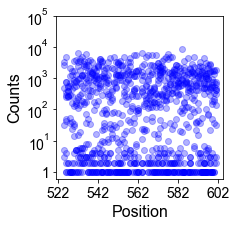

In [118]:
"""
The following code is to make the graph to show codon changes per position for sing codon changes and 
demonstrate the associated counts with these changes.
"""
def getUniqueMutation(AA_Change):
    string = AA_Change.replace('T563T','')
    string = string.replace(',','')
    return string
df_rpoB_donor_single = df_rpoB_donor.loc[df_rpoB_donor.No_Mutations == 2]
df_rpoB_donor_single = df_rpoB_donor_single.loc[df_rpoB_donor_single.AA_Change.str.find('T563T') >= 0]
df_rpoB_donor_single = df_rpoB_donor_single.loc[df_rpoB_donor_single.AA_Change.str.find('*') < 0]
df_rpoB_donor_single = df_rpoB_donor_single.assign(Unique_Mut = df_rpoB_donor_single.AA_Change.apply(getUniqueMutation))
df_rpoB_positionwise = df_rpoB_donor_single[['Unique_Mut','rpoB']]
df_rpoB_positionwise = df_rpoB_positionwise.assign(Position = pd.to_numeric(df_rpoB_positionwise.Unique_Mut.str[1:-1]))


fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(df_rpoB_positionwise.Position,np.log10(df_rpoB_positionwise.rpoB), color = 'blue', alpha = 0.3)
plt.yticks(np.arange(0,6,1),fontname="Arial",fontsize = 14)
ax.set_yticklabels(['1','$\mathregular{10^1}$','$\mathregular{10^2}$','$\mathregular{10^3}$','$\mathregular{10^4}$','$\mathregular{10^5}$'])
plt.xticks(np.arange(df_rpoB_positionwise.Position.min()-3,df_rpoB_positionwise.Position.max()+20,20),\
          fontname="Arial",fontsize = 14)
plt.xlabel('Position',fontname="Arial",fontsize = 16)
plt.ylabel('Counts',fontname="Arial",fontsize = 16)
plt.savefig('rpoB_countsbyposition.svg', format = 'svg', dpi = 300)

In [119]:
filter_value = 30
print filter_value

condition_B = (df_rpoB_donor.rpoB_lin >= filter_value) | (df_rpoB_donor.rpoB >= 30)

df_rpoB_donor = df_rpoB_donor.loc[condition_B]

30


C:\Users\alaks\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


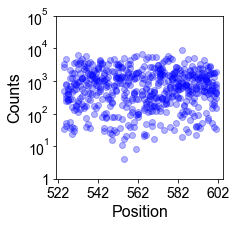

In [120]:
"""
The following code is to make the graph to show codon changes per position for sing codon changes and 
demonstrate the associated counts with these changes.

We observe that after applying the filter, we now have a cleaner graph with most mutations occurring only between 10^2 and 10^3 reads
"""
def getUniqueMutation(AA_Change):
    string = AA_Change.replace('T563T','')
    string = string.replace(',','')
    return string
df_rpoB_donor_single = df_rpoB_donor.loc[df_rpoB_donor.No_Mutations == 2]
df_rpoB_donor_single = df_rpoB_donor_single.loc[df_rpoB_donor_single.AA_Change.str.find('T563T') >= 0]
df_rpoB_donor_single = df_rpoB_donor_single.loc[df_rpoB_donor_single.AA_Change.str.find('*') < 0]
df_rpoB_donor_single = df_rpoB_
donor_single.assign(Unique_Mut = df_rpoB_donor_single.AA_Change.apply(getUniqueMutation))
df_rpoB_positionwise = df_rpoB_donor_single[['Unique_Mut','rpoB']]
df_rpoB_positionwise = df_rpoB_positionwise.assign(Position = pd.to_numeric(df_rpoB_positionwise.Unique_Mut.str[1:-1]))


fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(df_rpoB_positionwise.Position,np.log10(df_rpoB_positionwise.rpoB), color = 'blue', alpha = 0.3)
plt.yticks(np.arange(0,6,1),fontname="Arial",fontsize = 14)
ax.set_yticklabels(['1','$\mathregular{10^1}$','$\mathregular{10^2}$','$\mathregular{10^3}$','$\mathregular{10^4}$','$\mathregular{10^5}$'])
plt.xticks(np.arange(df_rpoB_positionwise.Position.min()-3,df_rpoB_positionwise.Position.max()+20,20),\
          fontname="Arial",fontsize = 14)
plt.xlabel('Position',fontname="Arial",fontsize = 16)
plt.ylabel('Counts',fontname="Arial",fontsize = 16)
plt.savefig('rpoB_countsbyposition.svg', format = 'svg', dpi = 300)

In [121]:
df_rpoB_positionwise.Position.value_counts().mean()

7.552631578947368

In [122]:
df_rpoB_positionwise.rpoB.median()

692.5

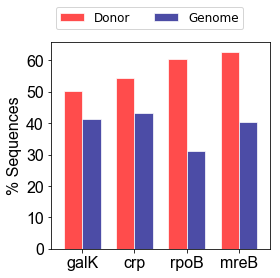

In [124]:
"""
The following code is to compare the percentage of synonymous mutations, stop codons and non-synonymous mutations between
galK, crp, mreB and rpoB
"""

xls = pd.ExcelFile('donorGenome.xlsx')
fig, ax = plt.subplots(figsize = (2,2))
df_rifR = pd.read_excel(xls, 'NonSyn')

df_rifR[['Donor','Genome']].plot(kind='bar', color = ['red','navy'],alpha = 0.7,\
                                                         width=0.7, \
                                               edgecolor = 'white', capsize = 2, figsize=(4,4), legend=False, ax=ax)
#plt.yscale('log')
plt.ylabel('% Sequences',  fontname="Arial",fontsize = 16)
plt.xlabel('',  fontname="Arial",fontsize = 1)
plt.xticks(fontname="Arial",fontsize = 16, rotation = 0, ha = 'center')
plt.yticks(fontname="Arial",fontsize = 16)
#ax.set_yticklabels(['1','$\mathregular{10^1}$','$\mathregular{10^2}$','$\mathregular{10^3}$','$\mathregular{10^4}$'])

plt.style.use('seaborn-pastel')
plt.legend(ncol = 3, loc = 'upper center', bbox_to_anchor = [0.45,1.2], fontsize = 12)
plt.style.use('seaborn-pastel')
plt.tight_layout()
plt.savefig('Donor_gen_Non_Syn.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

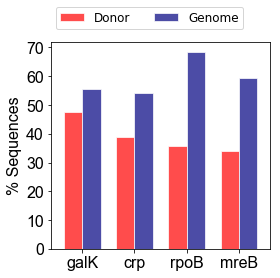

In [125]:
"""
The following code is to compare the percentage of synonymous mutations, stop codons and non-synonymous mutations between
galK, crp, mreB and rpoB
"""
fig, ax = plt.subplots(figsize = (2,2))
df_rifR = pd.read_excel(xls, 'Syn')

df_rifR[['Donor','Genome']].plot(kind='bar', color = ['red','navy'],alpha = 0.7,\
                                                         width=0.7, \
                                               edgecolor = 'white', capsize = 2, figsize=(4,4), legend=False, ax=ax)
#plt.yscale('log')
plt.ylabel('% Sequences',  fontname="Arial",fontsize = 16)
plt.xlabel('',  fontname="Arial",fontsize = 1)
plt.xticks(fontname="Arial",fontsize = 16, rotation = 0, ha = 'center')
plt.yticks(fontname="Arial",fontsize = 16)
#ax.set_yticklabels(['1','$\mathregular{10^1}$','$\mathregular{10^2}$','$\mathregular{10^3}$','$\mathregular{10^4}$'])

plt.style.use('seaborn-pastel')
plt.legend(ncol = 3, loc = 'upper center', bbox_to_anchor = [0.45,1.2], fontsize = 12)
plt.style.use('seaborn-pastel')
plt.tight_layout()
plt.savefig('Donor_gen_Syn.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

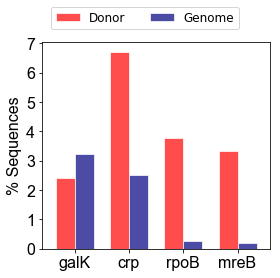

In [126]:
"""
The following code is to compare the percentage of synonymous mutations, stop codons and non-synonymous mutations between
galK, crp, mreB and rpoB
"""
fig, ax = plt.subplots(figsize = (2,2))
df_rifR = pd.read_excel(xls, 'Stop')

df_rifR[['Donor','Genome']].plot(kind='bar', color = ['red','navy'],alpha = 0.7,\
                                                         width=0.7, \
                                               edgecolor = 'white', capsize = 2, figsize=(4,4), legend=False, ax=ax)
#plt.yscale('log')
plt.ylabel('% Sequences',  fontname="Arial",fontsize = 16)
plt.xlabel('',  fontname="Arial",fontsize = 1)
plt.xticks(fontname="Arial",fontsize = 16, rotation = 0, ha = 'center')
plt.yticks(fontname="Arial",fontsize = 16)
#ax.set_yticklabels(['1','$\mathregular{10^1}$','$\mathregular{10^2}$','$\mathregular{10^3}$','$\mathregular{10^4}$'])

plt.style.use('seaborn-pastel')
plt.legend(ncol = 3, loc = 'upper center', bbox_to_anchor = [0.45,1.2], fontsize = 12)
plt.style.use('seaborn-pastel')
plt.tight_layout()
plt.savefig('Donor_gen_Stop.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

In [ ]:
"""
The following code is used to estimate the mutation per position for each genes
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pltsns
import time
import pandas as pd
import matplotlib.pyplot as plt

def readUsearchOutputTodf(filename):
    df_usearch = pd.read_csv(filename,delimiter='\t',\
                             names=['query','target','id','alnlen','mism','opens','qlo','qhi',\
                                    'tlo','thi','evalue','bits','qrow','trow','qrowdots','tstrand','qstrand']) 
    return df_usearch

def createMutationFrequencyTablefromUsearch(filename, seqLength):
    df_top = readUsearchOutputTodf(filename)
    df_trace = pd.DataFrame(index=['.','A','T','C','G','-'])
    for i in range(0,seqLength):
        df_trace_temp = df_top.qrowdots.str[i].value_counts('.').to_frame()
        df_trace_temp.columns = [i]
        df_trace = df_trace.join(df_trace_temp)
    df_mut = df_trace.transpose()
    df_mut = df_mut.fillna(0)
    df_mut['Mutation_Frequency'] = df_mut['A'] + df_mut['T'] + df_mut['C'] + df_mut['G']
    return df_mut

df_rpoB = createMutationFrequencyTablefromUsearch('Usearch/Init-Pre_assembled.fastq.txt')
df_crp = createMutationFrequencyTablefromUsearch('Usearch/C_assembled.fastq.txt')
df_mreB = createMutationFrequencyTablefromUsearch('Usearch/M_assembled.fastq.txt')

In [132]:
"""
We read the per position mutation data for each gene
"""
df_rpoB = pd.read_csv('Mutation_Freq/rpoB.csv', index_col=0)
df_crp = pd.read_csv('Mutation_Freq/crp.csv', index_col=0)
df_mreB = pd.read_csv('Mutation_Freq/mreB.csv', index_col=0)

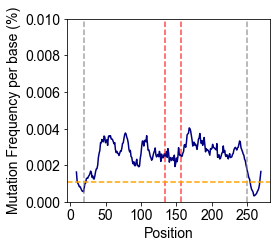

In [133]:
"""
We make the mutation/residue for each gene
"""
%matplotlib inline
control_mean = df_rpoB[:20].Mutation_Frequency.mean()
fig = plt.figure(figsize=(4,3.5))
df_rpoB.Mutation_Frequency.rolling(window=10).mean().plot(linestyle = '-',color = 'navy',\
                                                         label = 'rpoB', alpha = 1)

plt.ylim([0,0.01])
plt.ylabel('Mutation Frequency per base (%)',fontname = 'Arial', fontsize = 14)
plt.xlabel('Position',fontname = 'Arial',fontsize = 14)

plt.axvline(x = 134, color = 'red', linestyle = '--', label = '_nolegend_', alpha = 0.7)
plt.axvline(x = 157, color = 'red', linestyle = '--',  label = '_nolegend_',alpha = 0.7)

plt.axvline(x = 20, color = 'gray', linestyle = '--', label = '_nolegend_', alpha = 0.7)
plt.axvline(x = 250, color = 'gray', linestyle = '--',  label = '_nolegend_',alpha = 0.7)

plt.yticks(fontname = 'Arial',fontsize = 14)
plt.xticks(fontname = 'Arial',fontsize = 14)
plt.axhline(y = control_mean, color = 'orange', linestyle = '--',  label = '_nolegend_',alpha = 1)
plt.style.use('seaborn-pastel')
plt.tight_layout()
plt.savefig('rpoB_rolling.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

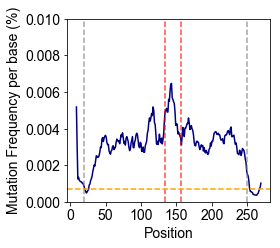

In [135]:
%matplotlib inline
df_crp = df_crp.drop([136])
control_mean = df_mreB[250:].Mutation_Frequency.mean()
fig = plt.figure(figsize=(4,3.5))
df_mreB.Mutation_Frequency.rolling(window=10).mean().plot(linestyle = '-',color = 'navy',\
                                                         label = 'rpoB', alpha = 1)
plt.ylim([0,0.01])
plt.ylabel('Mutation Frequency per base (%)',fontname = 'Arial', fontsize = 14)
plt.xlabel('Position',fontname = 'Arial',fontsize = 14)

plt.axvline(x = 134, color = 'red', linestyle = '--', label = '_nolegend_', alpha = 0.7)
plt.axvline(x = 157, color = 'red', linestyle = '--',  label = '_nolegend_',alpha = 0.7)

plt.axvline(x = 20, color = 'gray', linestyle = '--', label = '_nolegend_', alpha = 0.7)
plt.axvline(x = 250, color = 'gray', linestyle = '--',  label = '_nolegend_',alpha = 0.7)

plt.yticks(fontname = 'Arial',fontsize = 14)
plt.xticks(fontname = 'Arial',fontsize = 14)
plt.axhline(y = control_mean, color = 'orange', linestyle = '--',  label = '_nolegend_',alpha = 1)
plt.style.use('seaborn-pastel')
plt.tight_layout()
plt.savefig('mreB_rolling.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

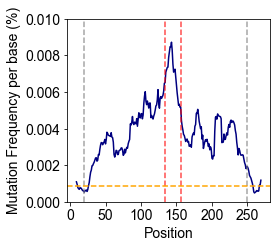

In [136]:
%matplotlib inline
control_mean = df_crp[250:].Mutation_Frequency.mean()
fig = plt.figure(figsize=(4,3.5))
df_crp.Mutation_Frequency.rolling(window=10).mean().plot(linestyle = '-',color = 'navy',\
                                                         label = 'rpoB', alpha = 1)
plt.ylim([0,0.01])
plt.ylabel('Mutation Frequency per base (%)',fontname = 'Arial', fontsize = 14)
plt.xlabel('Position',fontname = 'Arial',fontsize = 14)

plt.axvline(x = 134, color = 'red', linestyle = '--', label = '_nolegend_', alpha = 0.7)
plt.axvline(x = 157, color = 'red', linestyle = '--',  label = '_nolegend_',alpha = 0.7)

plt.axvline(x = 20, color = 'gray', linestyle = '--', label = '_nolegend_', alpha = 0.7)
plt.axvline(x = 250, color = 'gray', linestyle = '--',  label = '_nolegend_',alpha = 0.7)

plt.yticks(fontname = 'Arial',fontsize = 14)
plt.xticks(fontname = 'Arial',fontsize = 14)
plt.axhline(y = control_mean, color = 'orange', linestyle = '--',  label = '_nolegend_',alpha = 1)
plt.style.use('seaborn-pastel')
plt.tight_layout()
plt.savefig('crp_rolling.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

In [ ]:
"""
The following code gets mutation frequency for Rifampicin resistant colonies
"""
df_rif_mutL = createMutationFrequencyTablefromUsearch('Usearch/A-Pre_assembled.fastq.txt')
df_rif_zero = createMutationFrequencyTablefromUsearch('Usearch/11.fastq.txt')
df_rif_ten = createMutationFrequencyTablefromUsearch('Usearch/A-10_assembled.fastq.txt')
df_rif_fif = createMutationFrequencyTablefromUsearch('Usearch/A-50_assembled.fastq.txt')
df_rif_hun = createMutationFrequencyTablefromUsearch('Usearch/A-100_assembled.fastq.txt')
df_rif_zero = df_rif_zero.drop([135])
df_rif_mutL = df_rif_mutL.drop([135])
df_rif_ten = df_rif_ten.drop([135])
df_rif_fif = df_rif_fif.drop([135])
df_rif_hun = df_rif_hun.drop([135])

In [137]:
df_rif_mutL = pd.read_csv('Mutation_Freq/RifR-B_pre.csv')
df_rif_zero = pd.read_csv('Mutation_Freq/RifR-A_0.csv')
df_rif_ten = pd.read_csv('Mutation_Freq/RifR-B_10.csv')
df_rif_fif = pd.read_csv('Mutation_Freq/RifR-B_50.csv')
df_rif_hun = pd.read_csv('Mutation_Freq/RifR-B_100.csv')

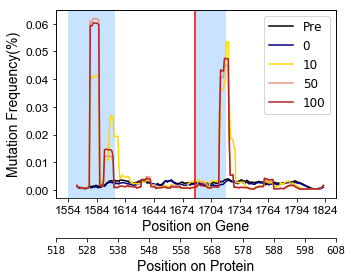

In [138]:
%matplotlib inline
fig = plt.figure(figsize=(5,4))
ax1 = plt.subplot(1,1,1)
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
ax1 = df_rif_mutL.Mutation_Frequency.rolling(window=10).mean().plot(linestyle = '-',color = 'black',\
                                                         label = 'Pre', alpha = 1)
ax1 = df_rif_zero.Mutation_Frequency.rolling(window=10).mean().plot(linestyle = '-',color = 'navy',\
                                                         label = '0', alpha = 1)
ax1 = df_rif_ten.Mutation_Frequency.rolling(window=10).mean().plot(linestyle = '-',color = 'gold',\
                                                         label = '10', alpha = 1)
ax1 = df_rif_fif.Mutation_Frequency.rolling(window=10).mean().plot(linestyle = '-',color = 'darksalmon',\
                                                         label = '50', alpha = 1)
ax1 = df_rif_hun.Mutation_Frequency.rolling(window=10).mean().plot(linestyle = '-',color = 'firebrick',\
                                                         label = '100', alpha = 1)
ax1.set_ylabel('Mutation Frequency(%)',fontname = 'Arial', fontsize = 14)
ax1.set_xlabel('Position on Gene',fontname = 'Arial',fontsize = 14)
ax1.set_xticks(np.arange(0,300,30))
ax1.set_xticklabels(1554+np.arange(0,300,30))
plt.yticks(fontname = 'Arial',fontsize = 12)
plt.xticks(fontname = 'Arial',fontsize = 12)
ax1.axvline(x = 133, color = 'red')
plt.style.use('seaborn-pastel')
plt.legend(ncol = 1, loc = 'upper right',fontsize = 12)

ax2 = ax1.twiny()
ax2.set_xticks(np.arange(0,300,30))
ax2.set_xticklabels(518+np.arange(0,300,30)/3,fontname = 'Arial',fontsize = 12)
ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 40))
ax2.set_xlabel('Position on Protein',fontname = 'Arial',fontsize = 14)
ax1.axvspan(0,49, alpha = 0.5)
ax1.axvspan(133,166, alpha = 0.5)
plt.tight_layout()
plt.savefig('RifR rolling.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

In [139]:
df_rif_ten = pd.read_csv('Mutation_Freq/RifR-dPAM_10.csv')
df_rif_fif = pd.read_csv('Mutation_Freq/RifR-dPAM_50.csv')
df_rif_hun = pd.read_csv('Mutation_Freq/RifR-dPAM_100.csv')

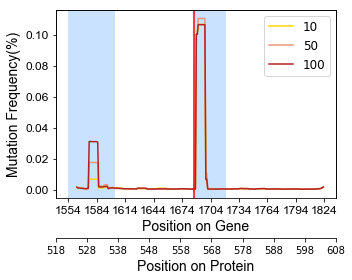

In [140]:
%matplotlib inline
fig = plt.figure(figsize=(5,4))
ax1 = plt.subplot(1,1,1)
plt.gcf().subplots_adjust(left = 0.15, bottom=0.15)
ax1 = df_rif_ten.Mutation_Frequency.rolling(window=10).mean().plot(linestyle = '-',color = 'gold',\
                                                         label = '10', alpha = 1)
ax1 = df_rif_fif.Mutation_Frequency.rolling(window=10).mean().plot(linestyle = '-',color = 'darksalmon',\
                                                         label = '50', alpha = 1)
ax1 = df_rif_hun.Mutation_Frequency.rolling(window=10).mean().plot(linestyle = '-',color = 'firebrick',\
                                                         label = '100', alpha = 1)
ax1.set_ylabel('Mutation Frequency(%)',fontname = 'Arial', fontsize = 14)
ax1.set_xlabel('Position on Gene',fontname = 'Arial',fontsize = 14)
ax1.set_xticks(np.arange(0,300,30))
ax1.set_xticklabels(1554+np.arange(0,300,30))
plt.yticks(fontname = 'Arial',fontsize = 12)
plt.xticks(fontname = 'Arial',fontsize = 12)
ax1.axvline(x = 133, color = 'red')
plt.style.use('seaborn-pastel')
plt.legend(ncol = 1, loc = 'upper right',fontsize = 12)

ax2 = ax1.twiny()
ax2.set_xticks(np.arange(0,300,30))
ax2.set_xticklabels(518+np.arange(0,300,30)/3,fontname = 'Arial',fontsize = 12)
ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 40))
ax2.set_xlabel('Position on Protein',fontname = 'Arial',fontsize = 14)
ax1.axvspan(0,49, alpha = 0.5)
ax1.axvspan(133,166, alpha = 0.5)
plt.tight_layout()
plt.savefig('RifR rolling control.svg',format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')

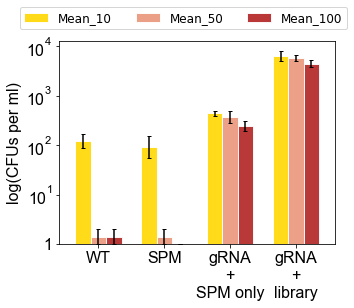

In [141]:
#Plotting Data for the Rifampicin selection
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
df_rifR = pd.read_csv('Rifampicin_bar.csv', index_col=0)
df_rifR_error = df_rifR[['std_10','std_50','std_100']]
df_rifR_error.columns = ['Mean_10','Mean_50','Mean_100']

df_rifR[['Mean_10','Mean_50','Mean_100']].plot(kind='bar', color = ['gold','darksalmon','firebrick'],\
                                                         yerr = df_rifR_error,alpha = 0.9,\
                                                         width=0.7, \
                                               edgecolor = 'white', capsize = 2, figsize=(5,4.5), legend=False, ax=ax)
#plt.yscale('log')
plt.ylabel('log(CFUs per ml)',  fontname="Arial",fontsize = 16)
plt.xlabel('',  fontname="Arial",fontsize = 1)
plt.xticks(fontname="Arial",fontsize = 16, rotation = 0, ha = 'center')
plt.yticks(np.arange(0,5,1),fontname="Arial",fontsize = 16)
ax.set_yticklabels(['1','$\mathregular{10^1}$','$\mathregular{10^2}$','$\mathregular{10^3}$','$\mathregular{10^4}$'])

plt.style.use('seaborn-pastel')
plt.legend(ncol = 3, loc = 'upper center', bbox_to_anchor = [0.45,1.2], fontsize = 12)
plt.tight_layout()

plt.savefig('RifR_Colonies.pdf',\
            format = 'pdf', dpi = 300, transparent = True, bbox_inches='tight')
plt.savefig('RifR_Colonies.tiff',\
            format = 'tiff', dpi = 300, transparent = True, bbox_inches='tight')
plt.savefig('RifR_Colonies.svg',\
            format = 'svg', dpi = 300, transparent = True, bbox_inches='tight')